In [ ]:
# Ref Big Dataset: https://www.kaggle.com/moltean/fruits

In [ ]:
import tensorflow as tf

In [ ]:
from glob import glob

In [ ]:
# Set the training path and validation path

train_path = 'fruits-small/fruits-small/data/Training/'
validation_path = 'fruits-small/fruits-small/data/Validation/'

In [ ]:
#Initialize Glob to interact with storage

image_files = glob(train_path +'/*/*.jp*g')
valid_image_files = glob(validation_path +'/*/*.jp*g')

In [ ]:
#Vgg16

#Step1: Create ImageGenerator object (Use Algo's preprocessing function)

gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                                      rotation_range=20,
                                                      shear_range=0.1,
                                                      zoom_range=0.2,
                                                      horizontal_flip=True,
                                                      vertical_flip=True)

In [ ]:
#Step2: Create Train and Valid Obj

train_generator = gen.flow_from_directory(train_path,
                                          target_size=[224,224],
                                          class_mode='categorical',
                                          batch_size=32)

valid_generator = gen.flow_from_directory(validation_path,
                                          target_size=[224,224],
                                          class_mode='categorical',
                                          batch_size=32)

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [ ]:
#Step3: Load the model with Training Enabled ! ---> 
#
# include_top=True -----> You will be using the pretrained model with Output FC Layer as 1000 classes (Training Disabled)
# include_top=False ----> Removing the FC layer

vgg = tf.keras.applications.vgg16.VGG16(input_shape=[224,224,3],
                                        weights="imagenet",
                                        include_top=False)

#Since I am following Approach 2 (Check Whiteboard Notes :) ), I will lock weights of CNN layer and removing ANN

for layer in vgg.layers:
  layer.trainable=False #If Approach 1--- True else False

In [ ]:
#Step4: Create FC layer

#Flatten

flatten = tf.keras.layers.Flatten()

# You can create your hidden layers here

# Output Layer

finalLayer = tf.keras.layers.Dense(7,activation="softmax")


In [ ]:
#Create Final Model

model = tf.keras.models.Sequential([
                                    vgg,
                                    flatten,
                                    finalLayer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 175623    
Total params: 14,890,311
Trainable params: 175,623
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#Compile

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Callbacks

# How to stop the training process if my model has converged successfully?
#
# Convergence Criteria:
# 1. Model must be a generalized model ( testScore > trainScore )
# 2. Model's Test Score >= CL
#
#
# Custom Callback which satisfies the above two criteria :)

class MyQualityThreshold(tf.keras.callbacks.Callback):
  def __init__(self,cl):
    super(MyQualityThreshold, self).__init__()
    self.cl = cl
  
  def on_epoch_end(self,epoch,logs=None):
    testScore = logs['val_accuracy']
    trainScore = logs['accuracy']

    if testScore > trainScore and testScore >= self.cl:
      self.model.stop_training=True

In [ ]:
#Fit Model 
batch_size=32
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    steps_per_epoch=len(train_generator.filenames) // batch_size,
                    validation_steps=len(valid_generator.filenames) // batch_size,
                    callbacks=[MyQualityThreshold(0.8)])

Epoch 1/100
107/107 [==============================] - 56s 522ms/step - loss: 0.4513 - accuracy: 0.9752 - val_loss: 0.1588 - val_accuracy: 0.9875


In [ ]:
#Saving Model
model.save("FruitsDetector")

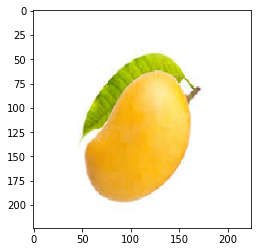

In [ ]:
#Deployment Example
#Load an Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

imageToPredict = tf.keras.preprocessing.image.load_img('mango.jpg', target_size=(224, 224))
plt.imshow(imageToPredict)

In [ ]:
#Step2: Convert image to np array 
myImageNPArray = tf.keras.preprocessing.image.img_to_array(imageToPredict)

myImageNPArray.shape

(224, 224, 3)

In [ ]:
# Step3: Make the image compatible for the model by adding n
myCompatibleImage = np.expand_dims(myImageNPArray, axis = 0)
myCompatibleImage.shape

(1, 224, 224, 3)

In [ ]:
#Step4: Prediction
prediction = model.predict(myCompatibleImage)

In [ ]:
prediction

array([[9.9999893e-01, 1.1322082e-06, 2.0560207e-19, 0.0000000e+00,
        0.0000000e+00, 6.1796632e-25, 9.1872010e-21]], dtype=float32)

In [ ]:
list(train_generator.class_indices)[np.argmax(prediction)]

'Banana'

In [ ]:
#Hunt Assignment !!!! --- Find Ans !!
from sklearn.metrics import confusion_matrix

predictedLabels = model.predict(?)
yActual = ?

cm = confusion_matrix()